## Imports

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graphviz
import pydotplus
import time

from random import randrange
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

from os import system
from IPython.display import Image

%matplotlib inline

## Load dataset

In [ ]:
# For further info https://archive.ics.uci.edu/ml/datasets/iris
iris = datasets.load_iris()
X = iris.data  
y = iris.target

#### Quick look into the data structure

In [ ]:
# Using pandas
data = pd.concat([pd.DataFrame(X),pd.DataFrame(y)], axis=1)
print(data)
data.columns=['a','b','c','d','target']
data.head(5)

       0    1    2    3  0
0    5.1  3.5  1.4  0.2  0
1    4.9  3.0  1.4  0.2  0
2    4.7  3.2  1.3  0.2  0
3    4.6  3.1  1.5  0.2  0
4    5.0  3.6  1.4  0.2  0
..   ...  ...  ...  ... ..
145  6.7  3.0  5.2  2.3  2
146  6.3  2.5  5.0  1.9  2
147  6.5  3.0  5.2  2.0  2
148  6.2  3.4  5.4  2.3  2
149  5.9  3.0  5.1  1.8  2

[150 rows x 5 columns]


,a,b,c,d,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


#### Exemplary plots

Text(0, 0.5, 'Sepal width')

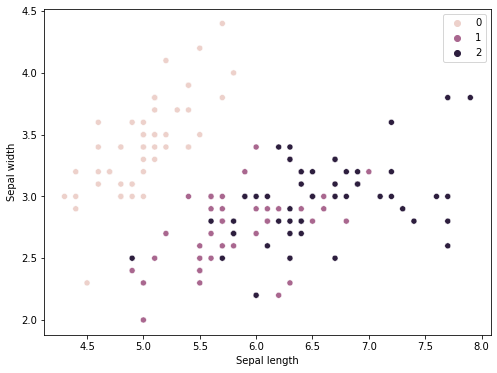

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

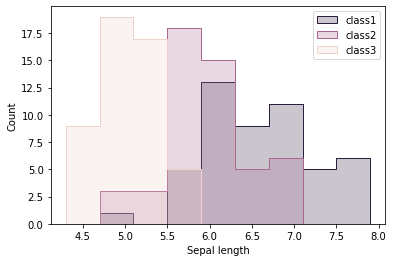

In [ ]:
# Univariate hist_plot 'sepal_length'
class0_index = [i for i, j in enumerate(y) if j==0]
class1_index = [i for i, j in enumerate(y) if j==1]
class2_index = [i for i, j in enumerate(y) if j==2]

sns.histplot(data=X, x=X[:,0], hue=y, element='step')
plt.xlabel('Sepal length')
plt.legend(('class1', 'class2','class3'))

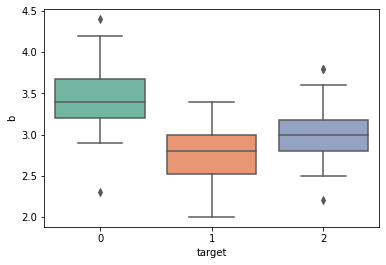

In [ ]:
# Barplot over 'sepal-width'
sns.boxplot(data=data, x = "target", y = "b", palette="Set2")

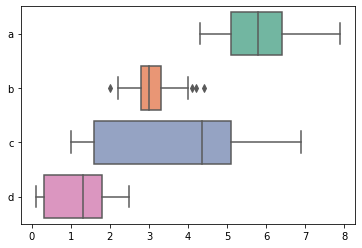

In [ ]:
# Boxplot of all features
sns.boxplot(data=data.iloc[:, :4], orient = "h", palette="Set2")

## Classification using decision trees 

#### Data preparation

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Decision tree form scratch

In [ ]:
class Node():
    def __init__(self, threshold = None, left = None, right = None, fea_index = None ):
        self.left = left
        self.right = right
        self.threshold = threshold
        self.feature_index = fea_index

class DT():
    def __init__(self, number_target_lable):
        self.num_tlable = number_target_lable
    
    """
        All class attributes must be designated in ascending order from zero
        All parentnodes have every time 2 childnodes
        The split point is determined by trying all permutations (for new childnodes) 
        of the target partitions
        The splitting criteria is calculated via information gain (smallest information 
        is best possible point
    """

    def fit (self, X, y):
        self.X_train = X
        self.Y_train = y


    def built_tree(self):
        root = Node(None, None, None, None)
        # in special eage cases no value form best split is returned
        # e. g. all sampels are assignt to one childnode 
        # -> no classification for on node left -> use random_num
        random_num = randrange(self.num_tlable)

        def help_built_tree(all_x, all_y, parent_node):
            threshold, feature, all_x_g, all_y_g, all_x_sEq, all_y_sEq = self.best_split_point(all_x, all_y)
            
            parent_node.threshold = threshold
            parent_node.feature_index = feature
            if len(all_y_g) == 0 or len(all_y_sEq) == 0:
                if len(all_y_g) == len(all_y_sEq) == 0:
                    parent_node.left = Node(None, random_num)
                    parent_node.right = Node(None, random_num)

                elif len(all_y_g) == 0:
                    parent_node.left = Node(None, all_y_sEq[0])
                    parent_node.right = Node(None, random_num)

                else:
                    parent_node.left = Node(None, random_num)
                    parent_node.right = Node(None, all_y_g[0])

            elif np.all(all_y_g == all_y_g[0]) and np.all(all_y_sEq == all_y_sEq[0]): 
                parent_node.left = Node(None, all_y_sEq[0])
                parent_node.right = Node(None,all_y_g[0])

            elif np.all(all_y_g == all_y_g[0]):
                new_parentnode = Node(None, None, None, None)
                parent_node.left = new_parentnode
                parent_node.right = Node(None,all_y_g[0])
                help_built_tree(all_x_sEq, all_y_sEq, new_parentnode)

            elif np.all(all_y_sEq == all_y_sEq[0]):
                new_parentnode = Node(None, None, None, None)
                parent_node.left = Node(None,all_y_sEq[0])
                parent_node.right = new_parentnode
                help_built_tree(all_x_g, all_y_g, new_parentnode)

            else:
                new_parentnode_l = Node(None, None, None, None)
                new_parentnode_r = Node(None, None, None, None)
                parent_node.left = new_parentnode_l
                parent_node.right = new_parentnode_r
                help_built_tree(all_x_sEq, all_y_sEq, new_parentnode_l), help_built_tree(all_x_g, all_y_g, new_parentnode_r)
        
        help_built_tree(self.X_train, self.Y_train, root)
        return root
        
        
    def best_split_point(self,x, y):
        """
        Input:  x all attributes, that a still left in the parentnode (other x_trian values assignt to another parendnodes)
                y all classe attribute, that a still left in the parentnode (other y_trian values assignt to another parendnodes)
        
        Output: np.array([
                            threshold
                            all_x_g_thr 
                            all_y_g_thr
                            all_x_sEq_thr
                            all_y_sEq_thr 
                        ])
                
                threshold is splitting criteria, for parentnode

                all_x_g_thr und all_y_g_thr form one childnode of the parentnode

                all_x_sEq_thr and all_y_sEqu_thr form one childnode of the parentnode
        """
        highest_informationGain = None
        best_split = []
    
        # go through all combinations of the class attributes e. g. class attibutes {0,1,2} => ({0}, {1,2}) ({1}, {0,2}) ({2}, {1,0})
        for partition in range(self.num_tlable):
            # calculate for every attribute the informaion gain
            # critiria for a possible splitt: 
            # sort attribute column ascending if the i and the i+1 value have a 
            # different class attribut, calculate the infoGain   
            for feature_index in range(np.shape(x)[1]):

                num_of_rows = len(y)
                index_to_sort_rows = x[:, feature_index].argsort()
                x_sorted = x[index_to_sort_rows]
                y_sorted = y[index_to_sort_rows]

                # search for best splitt 
                for i in range(num_of_rows-2):

                    # i and the i+1 value have a different class attribut -> calculate the infoGain
                    if (partition == y_sorted[i] and partition != y_sorted[i+1]) or (partition == y_sorted[i+1] and partition != y_sorted[i]):
                        
                        threshold = (x_sorted[i, feature_index] + x_sorted[i+1, feature_index])/2
                        
                        all_x_g_thr = x_sorted[ x_sorted[: ,feature_index] > threshold]
                        all_y_g_thr = y_sorted[ x_sorted[: ,feature_index] > threshold]

                        all_x_sEq_thr = x_sorted[ x_sorted[: ,feature_index] <= threshold]
                        all_y_sEq_thr = y_sorted[ x_sorted[: ,feature_index] <= threshold]

                        entropy = self.entropy(np.sum(y_sorted == partition), np.sum(y_sorted != partition))
                        sub_entropy_0 = self.entropy(np.sum(all_y_sEq_thr == partition), np.sum(all_y_sEq_thr != partition))
                        sub_entropy_1 = self.entropy(np.sum(all_y_g_thr == partition), np.sum(all_y_g_thr != partition))

                        informationGain = self.information_Gain(entropy, num_of_rows, len(all_y_g_thr), len(all_y_sEq_thr), sub_entropy_0, sub_entropy_1 )

                        if highest_informationGain == None or informationGain > highest_informationGain:
                            highest_informationGain = informationGain 
                            best_split = (threshold, feature_index, all_x_g_thr, all_y_g_thr, all_x_sEq_thr, all_y_sEq_thr)
        # If np.shape(x) <= 2 problem with: for i in range(num_of_rows-2):
        if np.shape(best_split)[0] != 6:
            return [0,0,0,[y[0]],0,[y[1]]]
        return best_split


    def entropy(self,p_plus, p_minus):
        if p_minus <= 0 or p_plus <= 0:
            return 0
        else:
            return - np.log2(p_plus) * - np.log2(p_minus)


    def information_Gain(self,entropy, num_of_rows, num_geater_than_t, num_smaller_equ_as_t, sub_entropy_0, sub_entropy_1):
        return entropy - (num_smaller_equ_as_t / num_of_rows) * sub_entropy_0 - (num_geater_than_t/ num_of_rows) * sub_entropy_1

    
    def predict(self, x_test, y_test, root):
        predicted_labels = [self._predict(x, root) for x in x_test]
        return 100/ np.shape(y_test)[0] * sum([ 1 for y_test_label, predicted_label in zip (y_test, predicted_labels ) if y_test_label == predicted_label]) 

    
    def _predict(self, x, root):
        current_node = root
        while current_node != None:
            if current_node.threshold == None:
                return current_node.left
            if x[current_node.feature_index] <= current_node.threshold:
                current_node = current_node.left
            else:
                current_node = current_node.right


def main(DT, Node):
    start_time = time.time()
    dt = DT(3)
    dt.fit(X_train, y_train) 
    root = dt.built_tree()
    print("Accuracy:", dt.predict(X_test, y_test, root))
    print("--- %s seconds ---" % (time.time() - start_time)) 

if __name__ == "__main__":
    main(DT, Node)
  

Accuracy: 90.0
--- 0.04956173896789551 seconds ---


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### Sklearn decision tree using GiniIndex + Visualization + Evaluation

In [ ]:
# Train a DT classifier 
start_time = time.time()

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("--- %s seconds ---" % (time.time() - start_time))   

Accuracy: 0.9666666666666667
--- 0.0034639835357666016 seconds ---


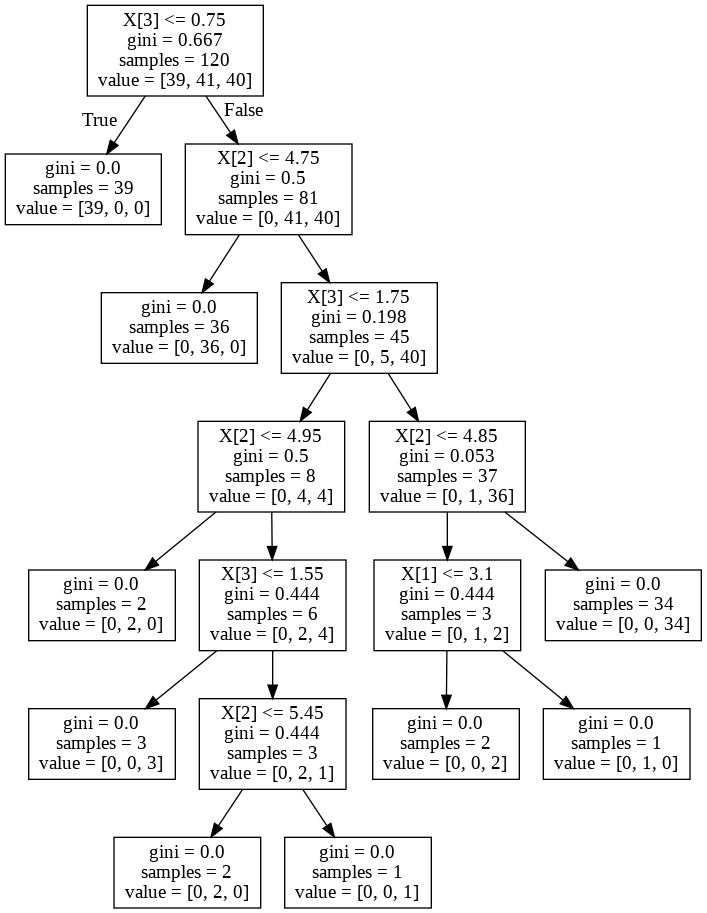

In [ ]:
# Visualize clf: Export to .png image file

tree.export_graphviz(clf, out_file='tree.dot') 
system("dot -Tpng tree.dot -o tree1.png")
Image("tree1.png")

In [ ]:
# Evaluation of the classifier's performance
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11  0  0]
 [ 0  9  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.90      1.00      0.95         9
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



#### Sklearn decision tree using Entropy + Visualization + Evaluation

In [ ]:
# Train the second classifier
start_time = time.time()

clf2 = DecisionTreeClassifier(criterion = "entropy")
clf2 = clf2.fit(X_train,y_train)
y_pred = clf2.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("--- %s seconds ---" % (time.time() - start_time))   

Accuracy: 0.9666666666666667
--- 0.00710296630859375 seconds ---


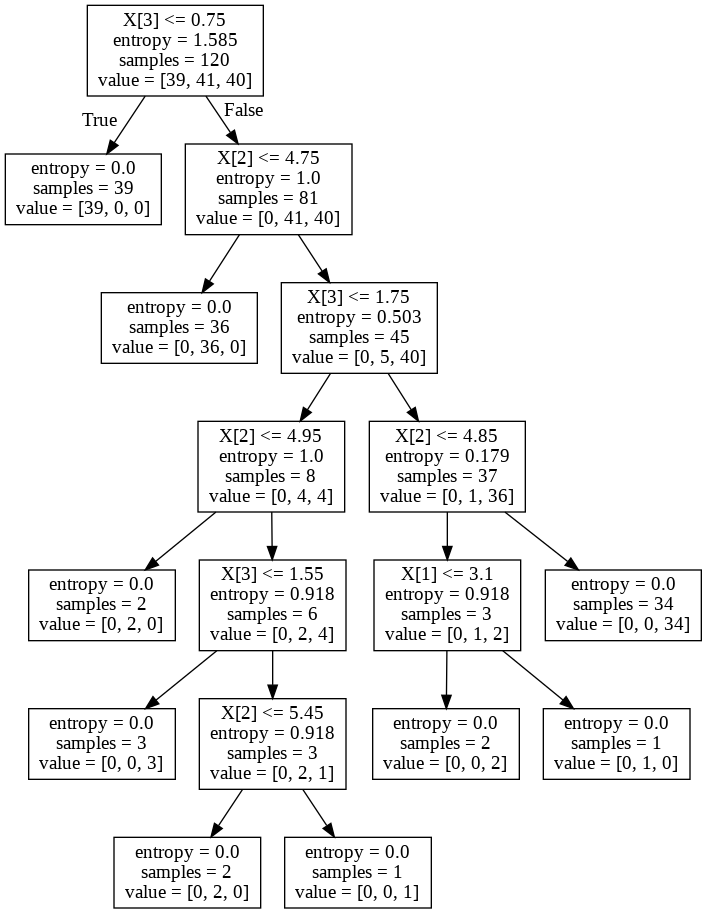

In [ ]:
# Visualize clf #2
tree.export_graphviz(clf2, out_file='tree2.dot') 
system("dot -Tpng tree2.dot -o tree2.png")
Image("tree2.png")

In [ ]:
# Evaluation of the classifier's performance
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11  0  0]
 [ 0  9  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.90      1.00      0.95         9
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30

